In [50]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import Input, Conv2D, PReLU, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import glob
from tqdm import tqdm
import random
import datetime
import time
import platform
import zipfile

In [51]:
# Mount Google Drive to access/save data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# setting these:
scale_factor = 2       # 2x upscaling
patch_size = 96        # Moderate patch size to avoid memory issues
batch_size = 32        # Balanced batch size for full dataset
epochs = 50            # Increased epochs for better convergence with full dataset

In [54]:
# Create output folders on Google Drive
output_dir = '/content/drive/MyDrive/Neural Network/PROJECT/OUTPUT'
model_dir = os.path.join(output_dir, 'models')
image_dir = os.path.join(output_dir, 'images')
log_dir = os.path.join(output_dir, 'logs')

In [55]:
for path in [output_dir, model_dir, image_dir, log_dir]:
    os.makedirs(path, exist_ok=True)

In [56]:
# Check for GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [57]:
# Enable mixed precision for faster training on compatible GPUs
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print("Mixed precision policy:", policy.name)

Mixed precision policy: mixed_float16


In [ ]:
'''
    Loads and processes the DIV2K dataset for super-resolution tasks.
    Handles matching high-resolution (HR) and low-resolution (LR) image pairs
    at different scale factors (x2, x4) for training and validation.
    Attributes:
        base_dir: Root directory containing the DIV2K dataset
        scale_factor: Super-resolution scale factor (2 or 4)
        patch_size: Size of HR patches used for training
        lr_patch_size: Size of LR patches (patch_size / scale_factor)
        batch_size: Number of samples per batch
'''
class DIV2KDataset:
    def __init__(self, base_dir, scale_factor=2, patch_size=96, batch_size=16):
        self.base_dir = base_dir
        self.scale_factor = scale_factor
        self.patch_size = patch_size
        self.lr_patch_size = patch_size // scale_factor
        self.batch_size = batch_size

        # DIV2K directory structure as provided
        self.hr_train_dir = os.path.join(base_dir, 'DIV2K_train_HR')
        self.lr_train_dir_x2 = os.path.join(base_dir, 'DIV2K_train_LR_bicubic', 'X2')
        self.lr_train_dir_x4 = os.path.join(base_dir, 'DIV2K_train_LR_bicubic_X4', 'X4')

        self.hr_valid_dir = os.path.join(base_dir, 'DIV2K_valid_HR')
        self.lr_valid_dir_x2 = os.path.join(base_dir, 'DIV2K_valid_LR_bicubic', 'X2')
        self.lr_valid_dir_x4 = os.path.join(base_dir, 'DIV2K_valid_LR_bicubic_X4', 'X4')

        # Select LR directory based on scale factor
        self.lr_train_dir = self.lr_train_dir_x2 if scale_factor == 2 else self.lr_train_dir_x4
        self.lr_valid_dir = self.lr_valid_dir_x2 if scale_factor == 2 else self.lr_valid_dir_x4

    def load_image_pairs(self):
        """Load and match HR and LR image pairs"""
        hr_train_files = sorted(glob.glob(os.path.join(self.hr_train_dir, '*.png')))
        hr_valid_files = sorted(glob.glob(os.path.join(self.hr_valid_dir, '*.png')))

        # Get the scale factor suffix
        scale_suffix = f"x{self.scale_factor}"

        # Create mapping for training images
        train_pairs = []
        for hr_path in hr_train_files:
            basename = os.path.basename(hr_path)
            image_id = os.path.splitext(basename)[0]  # e.g., "0001"
            lr_basename = f"{image_id}{scale_suffix}.png"  # e.g., "0001x2.png"
            lr_path = os.path.join(self.lr_train_dir, lr_basename)

            if os.path.exists(lr_path):
                train_pairs.append((hr_path, lr_path))

        # Create mapping for validation images
        valid_pairs = []
        for hr_path in hr_valid_files:
            basename = os.path.basename(hr_path)
            image_id = os.path.splitext(basename)[0]  # e.g., "0801"
            lr_basename = f"{image_id}{scale_suffix}.png"  # e.g., "0801x2.png"
            lr_path = os.path.join(self.lr_valid_dir, lr_basename)

            if os.path.exists(lr_path):
                valid_pairs.append((hr_path, lr_path))

        print(f"Found {len(train_pairs)} training pairs and {len(valid_pairs)} validation pairs")
        return train_pairs, valid_pairs

In [ ]:
"""
   Generates random patches from HR/LR image pairs for super-resolution training.
   Randomly extracts corresponding patches from high and low resolution images,
   normalizes pixel values to [0,1], and handles grayscale conversion to RGB.
    Yields an infinite sequence of (LR patch, HR patch) pairs.
"""
def patch_generator(image_pairs, patch_size, lr_patch_size, scale_factor):
    while True:
        for hr_path, lr_path in image_pairs:
            hr_img = np.array(Image.open(hr_path)) / 255.0
            lr_img = np.array(Image.open(lr_path)) / 255.0

            if len(hr_img.shape) == 2:
                hr_img = np.stack([hr_img] * 3, axis=-1)
            if len(lr_img.shape) == 2:
                lr_img = np.stack([lr_img] * 3, axis=-1)

            hr_h, hr_w, _ = hr_img.shape
            if hr_h < patch_size or hr_w < patch_size:
                continue

            hr_y = random.randint(0, hr_h - patch_size)
            hr_x = random.randint(0, hr_w - patch_size)
            lr_y = hr_y // scale_factor
            lr_x = hr_x // scale_factor

            hr_patch = hr_img[hr_y:hr_y+patch_size, hr_x:hr_x+patch_size, :]
            lr_patch = lr_img[lr_y:lr_y+(patch_size // scale_factor), lr_x:lr_x+(patch_size // scale_factor), :]

            yield lr_patch.astype(np.float32), hr_patch.astype(np.float32)

In [ ]:
"""
   Creates a TensorFlow dataset from image pairs for super-resolution training.
   Extracts random patches from each image pair, handles grayscale conversion,
   and configures dataset performance optimizations (shuffling, batching, prefetching).
   Returns a ready-to-use TF dataset that yields (LR patch, HR patch) pairs.
"""
def create_generator_tf_dataset(image_pairs, patch_size, scale_factor, batch_size, shuffle=True):
    """Create a TensorFlow dataset for image super-resolution training"""
    if len(image_pairs) == 0:
        raise ValueError("No image pairs provided")

    lr_patch_size = patch_size // scale_factor

    # Define the generator function
    def generator():
        for hr_path, lr_path in image_pairs:
            try:
                # Load images
                hr_img = np.array(Image.open(hr_path)) / 255.0
                lr_img = np.array(Image.open(lr_path)) / 255.0

                # Handle grayscale images
                if len(hr_img.shape) == 2:
                    hr_img = np.stack([hr_img] * 3, axis=-1)
                if len(lr_img.shape) == 2:
                    lr_img = np.stack([lr_img] * 3, axis=-1)

                hr_h, hr_w, _ = hr_img.shape
                if hr_h < patch_size or hr_w < patch_size:
                    continue

                # Generate random patch
                hr_y = random.randint(0, hr_h - patch_size)
                hr_x = random.randint(0, hr_w - patch_size)
                lr_y = hr_y // scale_factor
                lr_x = hr_x // scale_factor

                hr_patch = hr_img[hr_y:hr_y+patch_size, hr_x:hr_x+patch_size, :]
                lr_patch = lr_img[lr_y:lr_y+lr_patch_size, lr_x:lr_x+lr_patch_size, :]

                yield lr_patch.astype(np.float32), hr_patch.astype(np.float32)
            except Exception as e:
                print(f"Error processing {hr_path} or {lr_path}: {e}")
                continue

    # Create dataset with output specifications
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(lr_patch_size, lr_patch_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(patch_size, patch_size, 3), dtype=tf.float32)
        )
    )

    # Apply dataset transformations
    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    # Make sure dataset has elements (cache small datasets)
    if len(image_pairs) < 100:
        dataset = dataset.cache()

    # Take a specific number of items to ensure dataset is not empty
    dataset = dataset.take(max(1, len(image_pairs) * 4))

    return dataset

In [ ]:
"""
   Displays image samples for visual comparison of super-resolution results.
   Shows low-resolution inputs alongside high-resolution ground truth images.
   If super-resolution predictions are provided, displays them in the middle column.
   Optionally saves the visualization to a file.
"""
def visualize_samples(lr_imgs, hr_imgs, sr_imgs=None, num_samples=5, save_path=None):
    """Visualize sample images from the dataset"""
    num_samples = min(num_samples, len(lr_imgs))

    if sr_imgs is not None:
        plt.figure(figsize=(15, 5*num_samples))
        for i in range(num_samples):
            # Low resolution
            plt.subplot(num_samples, 3, i*3+1)
            plt.imshow(lr_imgs[i])
            plt.title(f"LR Input {lr_imgs[i].shape}")
            plt.axis('off')

            # Super resolution (prediction)
            plt.subplot(num_samples, 3, i*3+2)
            plt.imshow(sr_imgs[i])
            plt.title(f"SR Output {sr_imgs[i].shape}")
            plt.axis('off')

            # High resolution (ground truth)
            plt.subplot(num_samples, 3, i*3+3)
            plt.imshow(hr_imgs[i])
            plt.title(f"HR Ground Truth {hr_imgs[i].shape}")
            plt.axis('off')
    else:
        plt.figure(figsize=(10, 5*num_samples))
        for i in range(num_samples):
            # Low resolution
            plt.subplot(num_samples, 2, i*2+1)
            plt.imshow(lr_imgs[i])
            plt.title(f"LR Input {lr_imgs[i].shape}")
            plt.axis('off')

            # High resolution
            plt.subplot(num_samples, 2, i*2+2)
            plt.imshow(hr_imgs[i])
            plt.title(f"HR Ground Truth {hr_imgs[i].shape}")
            plt.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


In [ ]:
"""
   Fast Super-Resolution Convolutional Neural Network (FSRCNN) implementation.
   
   Implements the FSRCNN architecture for efficient single-image super-resolution,
   with configurable parameters for feature extraction, shrinking, and mapping depth.
   Supports different upscaling factors (2x, 3x, 4x) and includes PSNR and SSIM 
   metrics for quality evaluation.
"""
class FSRCNN:
    def __init__(self, scale_factor=2, learning_rate=0.001, num_channels=3):
        self.scale_factor = scale_factor
        self.learning_rate = learning_rate
        self.num_channels = num_channels

        # FSRCNN parameters - slightly reduced for faster training on free Colab
        self.d = 48  # Feature extraction filter size (reduced from 56)
        self.s = 10  # Shrinking filter size (reduced from 12)
        self.m = 3   # Mapping depth (reduced from 4)

    def get_config(self):
        # Add this method for TensorBoard serialization
        return {
            "scale_factor": self.scale_factor,
            "learning_rate": self.learning_rate,
            "num_channels": self.num_channels,
            "d": self.d,
            "s": self.s,
            "m": self.m
        }

    def build_model(self, input_shape):
        inputs = Input(shape=input_shape)

        # Feature extraction
        x = Conv2D(self.d, kernel_size=5, padding='same')(inputs)
        x = PReLU(shared_axes=[1, 2])(x)

        # Shrinking
        x = Conv2D(self.s, kernel_size=1, padding='same')(x)
        x = PReLU(shared_axes=[1, 2])(x)

        # Non-linear mapping
        for _ in range(self.m):
            x = Conv2D(self.s, kernel_size=3, padding='same')(x)
            x = PReLU(shared_axes=[1, 2])(x)

        # Expanding
        x = Conv2D(self.d, kernel_size=1, padding='same')(x)
        x = PReLU(shared_axes=[1, 2])(x)

        # Deconvolution (Upsampling)
        if self.scale_factor in [2, 3]:
            x = Conv2D(self.num_channels * (self.scale_factor ** 2), kernel_size=9, padding='same')(x)
            x = Lambda(lambda t: tf.nn.depth_to_space(t, self.scale_factor))(x)
        elif self.scale_factor == 4:
            x = Conv2D(self.num_channels * 4, kernel_size=9, padding='same')(x)
            x = Lambda(lambda t: tf.nn.depth_to_space(t, 2))(x)
            x = Conv2D(self.num_channels * 4, kernel_size=9, padding='same')(x)
            x = Lambda(lambda t: tf.nn.depth_to_space(t, 2))(x)

        model = Model(inputs=inputs, outputs=x)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                    loss='mse',
                    metrics=['mean_squared_error', self.psnr, self.ssim])

        return model

    def psnr(self, y_true, y_pred):
        """Calculate peak signal-to-noise ratio (PSNR)"""
        # Cast both tensors to float32 to ensure consistent types
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        return tf.image.psnr(y_true, y_pred, max_val=1.0)

    def ssim(self, y_true, y_pred):
        """Calculate structural similarity index (SSIM)"""
        # Cast both tensors to float32 to ensure consistent types
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [63]:
base_dir = '/content/drive/MyDrive/Neural Network/PROJECT/Dataset 2/'

In [65]:
# Print some system information
print("\nGPU Information:")
!nvidia-smi


GPU Information:
Tue Apr 15 23:54:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P0             26W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------

In [ ]:
#checking to see if the data is there
print(f"Checking dataset directory: {base_dir}")
print(f"Directory exists: {os.path.exists(base_dir)}")

Checking dataset directory: /content/drive/MyDrive/Neural Network/PROJECT/Dataset 2/
Directory exists: True


In [67]:
div2k = DIV2KDataset(base_dir, scale_factor, patch_size, batch_size)

In [68]:
# Verify directory structure
print("\nVerifying dataset structure:")
print(f"HR train dir: {div2k.hr_train_dir}")
print(f"HR train dir exists: {os.path.exists(div2k.hr_train_dir)}")
print(f"LR train dir: {div2k.lr_train_dir}")
print(f"LR train dir exists: {os.path.exists(div2k.lr_train_dir)}")
print(f"HR valid dir: {div2k.hr_valid_dir}")
print(f"HR valid dir exists: {os.path.exists(div2k.hr_valid_dir)}")
print(f"LR valid dir: {div2k.lr_valid_dir}")
print(f"LR valid dir exists: {os.path.exists(div2k.lr_valid_dir)}")


Verifying dataset structure:
HR train dir: /content/drive/MyDrive/Neural Network/PROJECT/Dataset 2/DIV2K_train_HR
HR train dir exists: True
LR train dir: /content/drive/MyDrive/Neural Network/PROJECT/Dataset 2/DIV2K_train_LR_bicubic/X2
LR train dir exists: True
HR valid dir: /content/drive/MyDrive/Neural Network/PROJECT/Dataset 2/DIV2K_valid_HR
HR valid dir exists: True
LR valid dir: /content/drive/MyDrive/Neural Network/PROJECT/Dataset 2/DIV2K_valid_LR_bicubic/X2
LR valid dir exists: True


In [69]:
train_pairs, valid_pairs = div2k.load_image_pairs()

# Split training and test pairs
random.shuffle(train_pairs)
test_size = max(5, int(0.05 * len(train_pairs)))
test_pairs = train_pairs[:test_size]

# Use all training pairs (instead of limiting to 200)
train_pairs = train_pairs[test_size:]

print(f"Number of training pairs: {len(train_pairs)}")
print(f"Number of validation pairs: {len(valid_pairs)}")
print(f"Number of test pairs: {len(test_pairs)}")

Found 800 training pairs and 100 validation pairs
Number of training pairs: 760
Number of validation pairs: 100
Number of test pairs: 40


In [70]:
# Verify pairs exist
if len(train_pairs) == 0:
    raise ValueError("No training pairs found!")

In [71]:
# Create datasets - use smaller validation set for speed
train_dataset = create_generator_tf_dataset(train_pairs, patch_size, scale_factor, batch_size, shuffle=True)
valid_dataset = create_generator_tf_dataset(valid_pairs[:50], patch_size, scale_factor, batch_size, shuffle=False)
test_dataset = create_generator_tf_dataset(test_pairs, patch_size, scale_factor, batch_size, shuffle=False)


In [72]:
# Calculate steps per epoch more conservatively
steps_per_epoch = max(1, (len(train_pairs) * 4) // batch_size)
val_steps = max(1, (min(50, len(valid_pairs)) * 2) // batch_size)

print(f"Training steps per epoch: {steps_per_epoch}")
print(f"Validation steps per epoch: {val_steps}")

Training steps per epoch: 95
Validation steps per epoch: 3


In [73]:
# Verify datasets
print("Checking datasets:")
try:
    sample_lr, sample_hr = next(iter(train_dataset))
    print(f"Training dataset: LR shape={sample_lr.shape}, HR shape={sample_hr.shape}")
except Exception as e:
    print(f"Error with training dataset: {e}")

Checking datasets:
Training dataset: LR shape=(32, 48, 48, 3), HR shape=(32, 96, 96, 3)


In [74]:
# Make sure the image directory exists
os.makedirs(image_dir, exist_ok=True)

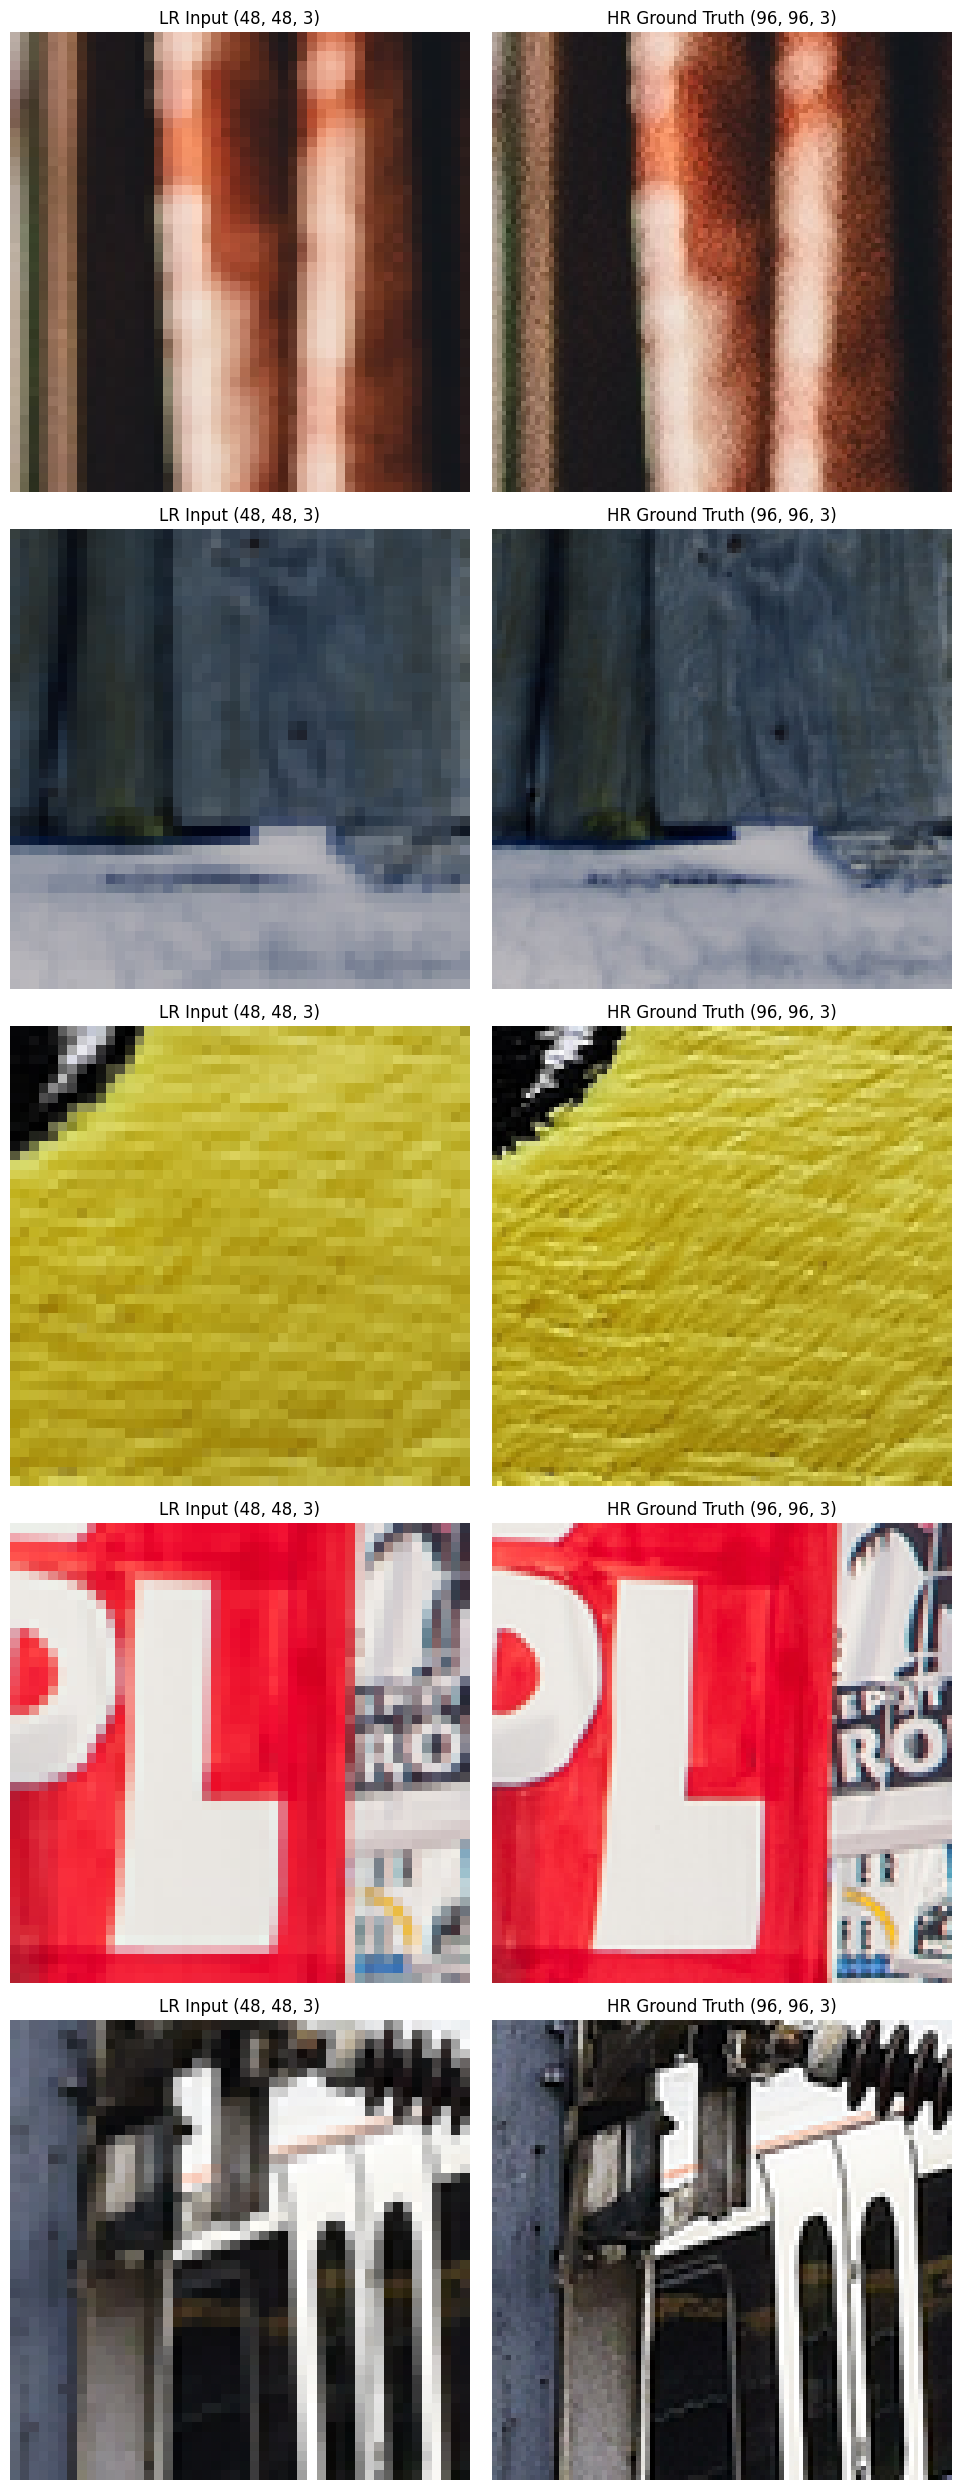

In [ ]:
#image smaples:
sample_lr, sample_hr = next(iter(train_dataset))
visualize_samples(sample_lr.numpy(), sample_hr.numpy(),
                  save_path=os.path.join(image_dir, 'training_samples.png'))

In [ ]:
# model:
fsrcnn = FSRCNN(scale_factor=scale_factor, learning_rate=0.001, num_channels=3)
model = fsrcnn.build_model(input_shape=(None, None, 3))  # Variable resolution
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, None, None, 48) │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, None, None, 48) │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 10) │           490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, None, None, 10) │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None, 10) │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, None, None, 10) │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, None, None, 10) │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_3 (PReLU)               │ (None, None, None, 10) │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, None, None, 10) │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_4 (PReLU)               │ (None, None, None, 10) │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, None, None, 48) │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_5 (PReLU)               │ (None, None, None, 48) │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, None, None, 12) │        46,668 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, None, None, 3)  │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,200 (211.72 KB)

 Trainable params: 54,200 (211.72 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
'''
Callbacks configuration for model training:
- Saves best model weights based on validation PSNR
- Saves checkpoint every 2 epochs for backup
- Reduces learning rate when training plateaus
- Logs metrics to TensorBoard for visualization
- Implements early stopping to prevent overfitting
'''
checkpoint_cb = ModelCheckpoint(
    os.path.join(model_dir, 'fsrcnn_best.weights.h5'),
    monitor='val_psnr',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Add a checkpoint to save every 2 epochs
checkpoint_frequent = ModelCheckpoint(
    os.path.join(model_dir, 'fsrcnn_epoch_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_best_only=False,  # Save regardless of performance
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5,
    patience=5, min_lr=1e-6, verbose=1
)

timestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_cb = TensorBoard(log_dir=os.path.join(log_dir, timestamp),
                           histogram_freq=1)

early_stop = EarlyStopping(
    monitor='val_psnr',
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [ ]:
# prints estimated time based on the hardware: (this one was for my own undrestanding)
print(f"Estimated training time with T4 GPU for full dataset:")
print(f"- {len(train_pairs)} training pairs")
print(f"- {epochs} epochs")
print(f"- Approximately {len(train_pairs) * epochs * 0.05:.1f}-{len(train_pairs) * epochs * 0.1:.1f} minutes")
print("Note: Keep Colab tab active to prevent disconnection")

Estimated training time with T4 GPU for full dataset:
- 760 training pairs
- 50 epochs
- Approximately 1900.0-3800.0 minutes
Note: Keep Colab tab active to prevent disconnection


In [79]:
# Start timer to measure actual training time
start_time = time.time()

In [ ]:
#model being fitted:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    epochs=epochs,
    callbacks=[checkpoint_cb, checkpoint_frequent, reduce_lr_cb, tensorboard_cb, early_stop],
    verbose=1
)

Epoch 1/50
24/95 ━━━━━━━━━━━━━━━━━━━━ 1:20:05 68s/step - loss: 0.1361 - mean_squared_error: 0.1361 - psnr: 11.1375 - ssim: 0.1689

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_psnr improved from -inf to 16.60970, saving model to /content/drive/MyDrive/Neural Network/PROJECT/OUTPUT/models/fsrcnn_best.weights.h5

Epoch 1: saving model to /content/drive/MyDrive/Neural Network/PROJECT/OUTPUT/models/fsrcnn_epoch_01.weights.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 1956s 20s/step - loss: 0.0919 - mean_squared_error: 0.0919 - psnr: 12.8816 - ssim: 0.2228 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_psnr: 16.6097 - val_ssim: 0.3869 - learning_rate: 0.0010
Epoch 2/50
24/95 ━━━━━━━━━━━━━━━━━━━━ 5:34 5s/step - loss: 0.0285 - mean_squared_error: 0.0285 - psnr: 16.6298 - ssim: 0.3668
Epoch 2: val_psnr improved from 16.60970 to 19.50356, saving model to /content/drive/MyDrive/Neural Network/PROJECT/OUTPUT/models/fsrcnn_best.weights.h5

Epoch 2: saving model to /content/drive/MyDrive/Neural Network/PROJECT/OUTPUT/models/fsrcnn_epoch_02.weights.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - loss: 0.0266 - mean_squared_error: 0.0266 - psnr: 17.0839 - ssim: 0.393

In [81]:
training_time = time.time() - start_time
hours, remainder = divmod(training_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"\nTotal training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")


Total training time: 2h 23m 3s


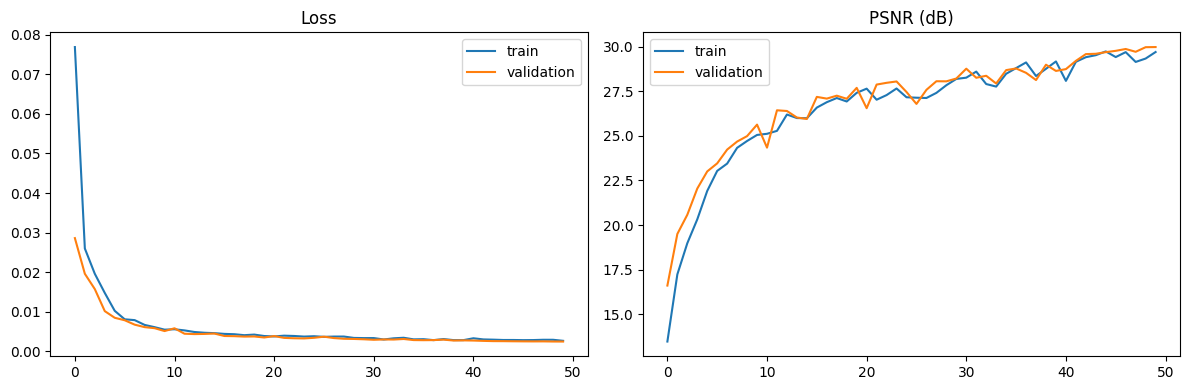

In [ ]:
# lurning curve plot:
import json
with open(os.path.join(output_dir, 'training_history.json'), 'w') as f:
    json.dump(str(history.history), f)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['psnr'], label='train')
plt.plot(history.history['val_psnr'], label='validation')
plt.title('PSNR (dB)')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(image_dir, 'training_history.png'))
plt.show()

In [ ]:
#saving best model:
model.load_weights(os.path.join(model_dir, 'fsrcnn_best.weights.h5'))
print("✅ Best model weights loaded.")

✅ Best model weights loaded.


In [ ]:
# testing:
print("Evaluating on test dataset...")
test_steps = max(1, (len(test_pairs) * 4) // batch_size)
test_results = model.evaluate(test_dataset, steps=test_steps)

print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test PSNR: {test_results[1]:.4f} dB")
print(f"Test SSIM: {test_results[2]:.4f}")


Evaluating on test dataset...
5/5 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - loss: 0.0021 - mean_squared_error: 0.0021 - psnr: 30.6697 - ssim: 0.8248 
Test Loss: 0.0021
Test PSNR: 0.0021 dB
Test SSIM: 30.7312


In [85]:
with open(os.path.join(output_dir, 'test_results.txt'), 'w') as f:
    f.write(f"Test Loss: {test_results[0]:.4f}\n")
    f.write(f"Test PSNR: {test_results[1]:.4f} dB\n")
    f.write(f"Test SSIM: {test_results[2]:.4f}\n")

In [86]:
def prepare_for_display(img_batch):
    # Convert to float32 if needed
    images = img_batch.astype(np.float32)
    # Clip to valid range [0, 1]
    images = np.clip(images, 0, 1)
    return images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


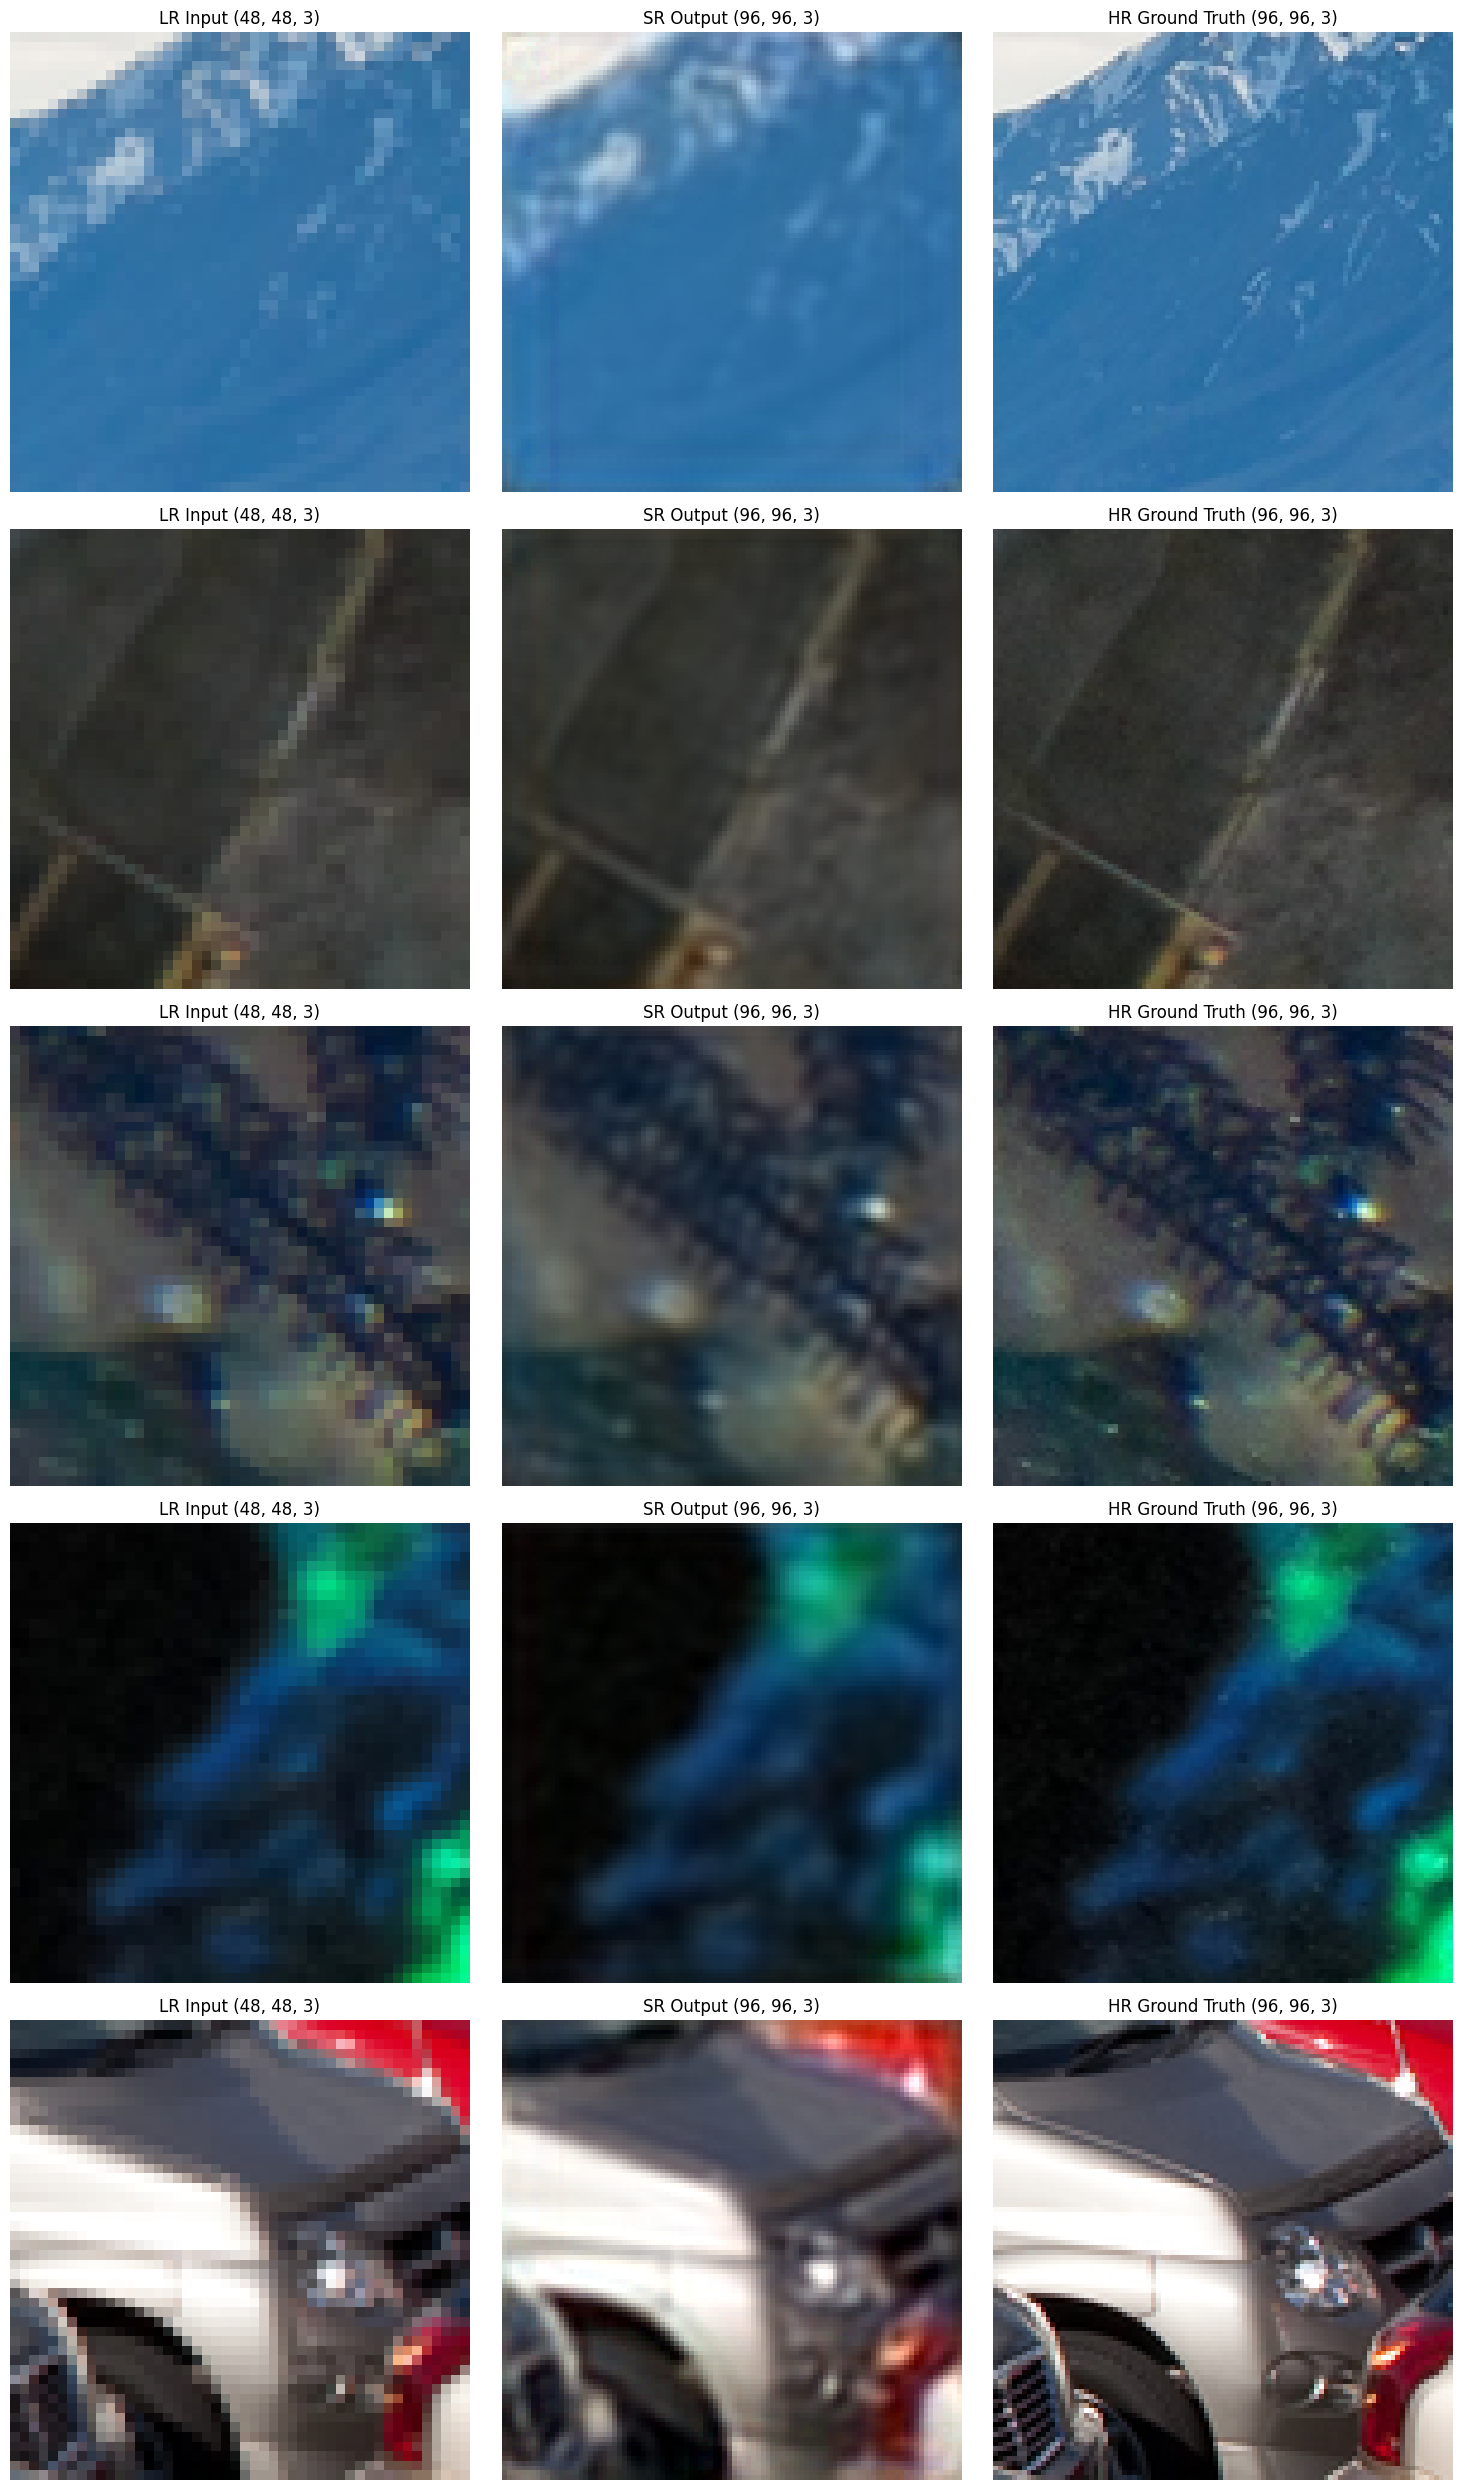

In [87]:
lr_batch, hr_batch = next(iter(test_dataset.take(1)))
sr_batch = model.predict(lr_batch)

# Visualize predictions
visualize_samples(
    lr_imgs=prepare_for_display(lr_batch.numpy()[:5]),
    hr_imgs=prepare_for_display(hr_batch.numpy()[:5]),
    sr_imgs=prepare_for_display(sr_batch[:5]),
    save_path=os.path.join(image_dir, 'test_results.png')
)

In [88]:
model.save(os.path.join(model_dir, 'fsrcnn_final_model.h5'))
print(f"✅ Model saved to {os.path.join(model_dir, 'fsrcnn_final_model.h5')}")


✅ Model saved to /content/drive/MyDrive/Neural Network/PROJECT/OUTPUT/models/fsrcnn_final_model.h5


In [ ]:
# trying to build an interface:
inference_code = """
def super_resolve_image(model_path, image_path, output_path, scale_factor=2):
    '''Super-resolve a low-resolution image using the trained FSRCNN model'''
    import tensorflow as tf
    import numpy as np
    from PIL import Image
    import os

    # Load model
    model = tf.keras.models.load_model(model_path,
                                     custom_objects={'psnr': tf.image.psnr,
                                                    'ssim': tf.image.ssim})

    # Load image
    img = np.array(Image.open(image_path).convert('RGB')) / 255.0

    # Ensure image has proper dimensions
    if len(img.shape) != 3 or img.shape[2] != 3:
        img = np.stack([img] * 3, axis=-1)

    # Add batch dimension
    img = np.expand_dims(img, axis=0)

    # Predict
    sr_img = model.predict(img)

    # Convert to uint8 and save
    sr_img = np.clip(sr_img[0] * 255, 0, 255).astype(np.uint8)
    Image.fromarray(sr_img).save(output_path)
    print(f"Super-resolved image saved to {output_path}")

# Example usage:
# 1. Upload a low-resolution image to Colab
# from google.colab import files
# uploaded = files.upload()  # This will prompt you to upload an image
# image_filename = list(uploaded.keys())[0]

# 2. Super-resolve the image
# model_path = '/content/drive/MyDrive/fsrcnn_results/models/fsrcnn_final_model.h5'
# input_image = image_filename
# output_image = 'super_resolved_' + image_filename
# super_resolve_image(model_path, input_image, output_image)

# 3. Display the results
# from IPython.display import Image as IPImage
# from IPython.display import display
# print("Original Image:")
# display(IPImage(input_image))
# print("Super-Resolved Image:")
# display(IPImage(output_image))

# 4. Download the super-resolved image
# files.download(output_image)
"""

with open(os.path.join(output_dir, 'inference.py'), 'w') as f:
    f.write(inference_code)

# Create a separate notebook for inference
inference_notebook = """
{
 "cells": [
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# FSRCNN Image Super-Resolution\n",
    "\n",
    "This notebook demonstrates how to use your trained FSRCNN model to super-resolve any image."
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "source": [
    "from google.colab import drive\n",
    "drive.mount('/content/drive')"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "source": [
    "# Import the inference function\n",
    "import sys\n",
    "import os\n",
    "\n",
    "# Update this path to where your inference.py file is saved\n",
    "sys.path.append('/content/drive/MyDrive/fsrcnn_results')\n",
    "from inference import super_resolve_image"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "source": [
    "# Upload a low-resolution image\n",
    "from google.colab import files\n",
    "uploaded = files.upload()  # This will prompt you to upload an image\n",
    "image_filename = list(uploaded.keys())[0]"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "source": [
    "# Super-resolve the image\n",
    "model_path = '/content/drive/MyDrive/fsrcnn_results/models/fsrcnn_final_model.h5'\n",
    "input_image = image_filename\n",
    "output_image = 'super_resolved_' + image_filename\n",
    "super_resolve_image(model_path, input_image, output_image)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "source": [
    "# Display the results\n",
    "import matplotlib.pyplot as plt\n",
    "from PIL import Image\n",
    "import numpy as np\n",
    "\n",
    "fig, axes = plt.subplots(1, 2, figsize=(12, 6))\n",
    "\n",
    "# Original image\n",
    "img_lr = np.array(Image.open(input_image))\n",
    "axes[0].imshow(img_lr)\n",
    "axes[0].set_title(f'Original ({img_lr.shape[0]}×{img_lr.shape[1]})')\n",
    "axes[0].axis('off')\n",
    "\n",
    "# Super-resolved image\n",
    "img_sr = np.array(Image.open(output_image))\n",
    "axes[1].imshow(img_sr)\n",
    "axes[1].set_title(f'Super-Resolved ({img_sr.shape[0]}×{img_sr.shape[1]})')\n",
    "axes[1].axis('off')\n",
    "\n",
    "plt.tight_layout()\n",
    "plt.savefig('comparison.png')\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "source": [
    "# Download the super-resolved image\n",
    "files.download(output_image)\n",
    "files.download('comparison.png')"
   ]
  }
 ],
 "metadata": {
  "accelerator": "GPU",
  "colab": {
   "gpuType": "T4",
   "provenance": []
  },
  "kernelspec": {
   "display_name": "Python 3",
   "name": "python3"
  },
  "language_info": {
   "name": "python"
  }
 },
 "nbformat": 4,
 "nbformat_minor": 0
}
"""

with open(os.path.join(output_dir, 'inference_demo.ipynb'), 'w') as f:
    f.write(inference_notebook)

print("✅ Training and evaluation complete!")
print("✅ Inference code and demo notebook saved to Google Drive")
print(f"📁 All results saved to: {output_dir}")

✅ Training and evaluation complete!
✅ Inference code and demo notebook saved to Google Drive
📁 All results saved to: /content/drive/MyDrive/Neural Network/PROJECT/OUTPUT
